In [17]:
import pandas as pd
import datetime
from tqdm import tqdm
import os
import time

import praw
import pandas as pd
from praw.models import MoreComments
import prawcore

from http.client import FORBIDDEN


In [18]:
def convert_time(utc_time):
    utc_datetime = datetime.datetime.utcfromtimestamp(utc_time)
    return utc_datetime

In [19]:
def make_reddit_request(url):
    while True:
        try:
            return reddit.submission(url=url)
        except prawcore.exceptions.TooManyRequests as e:
            print(f"Rate limit exceeded. Waiting before retrying. Error: {e}")
            # Wait for a while before retrying (e.g., 30 seconds)
            time.sleep(30)

In [3]:
csvs = ['slaap.csv',
        'slptap.csv',
        'getl.csv',
        'cm.csv',
        'srsa.csv',
        'csa.csv',
        'mapm.csv',
        'fvap.csv',
        'wea.csv',
        'nst.csv',
        'srns.csv',
        'wma.csv',
        'wql.csv',
        'glol.csv',
        'wila.csv']

In [4]:
path = "/Users/jennifermei/Downloads/auth/csv"

In [5]:
all_data = pd.DataFrame()

for csv in csvs:
    file = os.path.join(path, csv)
    df_to_add = pd.read_csv(file)
    all_data = pd.concat([all_data, df_to_add], ignore_index=True)

In [6]:
columns = ['archived', 'created_utc', 'id', 'subreddit_name_prefixed', 'score', 'title', 'url']

all_data = all_data[columns]
all_data['created_utc'] = all_data['created_utc'].apply(convert_time)
all_data = all_data[all_data['id'] != '9mb1gx']
all_data = all_data.drop_duplicates()

all_data.to_csv('final.csv', index=False)

In [7]:
from fake_useragent import UserAgent
ua = UserAgent()

In [8]:
reddit = praw.Reddit(client_id='y3yjek_o47TqtxcWpZavQg',
                     client_secret='FlmHsiAKijN4kuuYIOtRG_LO7UBzJQ',
                     user_agent=ua.chrome)

In [9]:
df = pd.read_csv('final.csv')
print(df.head())

   archived          created_utc       id subreddit_name_prefixed  score  \
0     False  2024-02-10 05:23:29  1an8vbe           r/RedWorldMod     71   
1     False  2023-09-15 09:59:07  16j921x         r/IdeologyPolls      7   
2     False  2024-02-19 07:10:03  1auh9gn       r/PostWorldPowers      5   
3     False  2022-03-10 23:19:03   tbby4a     r/InvasionOfUkraine     83   
4     False  2024-01-24 00:35:25  19e3vns            r/neoliberal     42   

                                               title  \
0                      The Central America Dev Diary   
1  Which faction would you join in this scenario,...   
2              [CLAIM]The Dakotas Interstate Compact   
3  Analysis of Vladimir Putin and Volodymyr Zelen...   
4  Why Trump supporters are so loyal - A brief hi...   

                                                 url  
0  https://www.reddit.com/r/RedWorldMod/comments/...  
1  https://www.reddit.com/r/IdeologyPolls/comment...  
2  https://www.reddit.com/r/PostWorldPowe

In [20]:
top_comments = []
post_bodies = []

for url in tqdm(df['url']):
    try:
        # check valid url
        if 'https://www.reddit.com/r/' not in url:
            top_comments.append('None')
            post_bodies.append('None')
            continue

        submission = make_reddit_request(url)

        if len(submission.comments) == 0:
            top_comments.append('None')
        else:
            # initialize to None in case all comments are from AutoModerator
            top_comment_body = None
            for comment in submission.comments.list():
                if comment.author != 'AutoModerator':
                    top_comment_body = comment.body
                    break  

            top_comments.append(top_comment_body if top_comment_body else 'None')

        # content of submission
        content = submission.selftext
        post_bodies.append(content)

    except (praw.exceptions.RedditAPIException, praw.exceptions.PRAWException, prawcore.exceptions.Forbidden) as e:
        print(f"Error processing URL {url}: {e}")
        top_comments.append('Error')
        post_bodies.append('Error')

df['top_comment'] = top_comments
df['post_text'] = post_bodies

df.to_csv('final_text.csv', index=False)

 86%|████████▋ | 1751/2025 [18:16<01:08,  3.97it/s]

Error processing URL https://www.reddit.com/r/The_Donald/comments/58fu58/i_know_its_just_mental_masturbation_but_sometimes/: received 403 HTTP response


100%|██████████| 2025/2025 [21:46<00:00,  1.55it/s]


In [44]:
print(pd.read_csv('final_text.csv').head())

   archived          created_utc       id subreddit_name_prefixed  score  \
0     False  2024-02-10 05:23:29  1an8vbe           r/RedWorldMod     71   
1     False  2023-09-15 09:59:07  16j921x         r/IdeologyPolls      7   
2     False  2024-02-19 07:10:03  1auh9gn       r/PostWorldPowers      5   
3     False  2022-03-10 23:19:03   tbby4a     r/InvasionOfUkraine     83   
4     False  2024-01-24 00:35:25  19e3vns            r/neoliberal     42   

                                               title  \
0                      The Central America Dev Diary   
1  Which faction would you join in this scenario,...   
2              [CLAIM]The Dakotas Interstate Compact   
3  Analysis of Vladimir Putin and Volodymyr Zelen...   
4  Why Trump supporters are so loyal - A brief hi...   

                                                 url  \
0  https://www.reddit.com/r/RedWorldMod/comments/...   
1  https://www.reddit.com/r/IdeologyPolls/comment...   
2  https://www.reddit.com/r/PostWorldP

### TRYING US VERSUS THEM

In [22]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
keep = {'we', 'our', 'us', 'they', 'their', "they're", 'them'}
stop_words = stop_words - keep

def preprocess_text(text):
    text = text.lower()  # text to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # remove text in brackets
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-z0-9\s]', '', text)  # remove punctuation and non-alphanumeric characters
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # lemmatize words and remove stopwords
    return ' '.join(words)

# csv data
df_uvt = pd.read_csv('final_text.csv')

for index, row in df_uvt.iterrows():
    text = row['post_text']
    comment = row['top_comment']
    if type(text) != str:
        df_uvt.drop(index, inplace=True)
    elif type(comment) != str:
        df_uvt.drop(index, inplace=True)

# preprocess text data
df_uvt['post_text'] = df_uvt['post_text'].apply(preprocess_text)
df_uvt['title'] = df_uvt['title'].apply(preprocess_text)
df_uvt['top_comment'] = df_uvt['top_comment'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jennifermei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jennifermei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
us_words = ["we", "our", "us"]
them_words = ["they", "their", "they're", "them"]

# count mentions and extract context
def count_mentions_and_context(text, lexicon):
    mention_count = 0
    context = []
    words = text.split()
    for i, word in enumerate(words):
        if word in lexicon:
            mention_count += 1
            # extract words before and after for context
            context_window = words[max(i-5, 0):min(i+6, len(words))]
            context.append(' '.join(context_window))
    return mention_count, context

df_uvt['us_mentions'], df_uvt['us_context'] = zip(*df_uvt['post_text'].apply(lambda x: count_mentions_and_context(x, us_words)))
df_uvt['them_mentions'], df_uvt['them_context'] = zip(*df_uvt['post_text'].apply(lambda x: count_mentions_and_context(x, them_words)))


In [24]:
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# sentiment analysis of context
def analyze_sentiment(contexts):
    sentiments = [sia.polarity_scores(context)['compound'] for context in contexts]
    return sentiments

df_uvt['us_sentiments'] = df_uvt['us_context'].apply(analyze_sentiment)
df_uvt['them_sentiments'] = df_uvt['them_context'].apply(analyze_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jennifermei/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [25]:
df_uvt.head()

,archived,created_utc,id,subreddit_name_prefixed,score,title,url,top_comment,post_text,us_mentions,us_context,them_mentions,them_context,us_sentiments,them_sentiments
0,False,2024-02-10 05:23:29,1an8vbe,r/RedWorldMod,71,central america dev diary,https://www.reddit.com/r/RedWorldMod/comments/...,youre amazing job developing red world im look...,buenos dia welcome another red world dev diary...,5,[dissatisfied brother unorthodox adherence san...,28,[plague young state new tracing their origin w...,"[-0.8519, -0.3818, 0.3412, 0.0, -0.0516]","[0.0, 0.8225, 0.4939, 0.4019, 0.5859, 0.296, 0..."
1,False,2023-09-15 09:59:07,16j921x,r/IdeologyPolls,7,faction would join scenario set 2035 america s...,https://www.reddit.com/r/IdeologyPolls/comment...,save our mother earth alien attack,2035 america whether youre american find stran...,1,[evidence pile half population belief we alone...,107,[specie originated earth one know they want wo...,[-0.6124],"[0.0772, 0.3818, 0.0, 0.296, 0.5574, 0.5106, 0..."
3,False,2022-03-10 23:19:03,tbby4a,r/InvasionOfUkraine,83,analysis vladimir putin volodymyr zelensky aut...,https://www.reddit.com/r/InvasionOfUkraine/com...,stellar beautifully scripted wildly accurate l...,part xvii analysis vladimir putin end present ...,0,[],7,[grand prince kievanrus panslavic people they ...,[],"[0.4588, 0.0516, -0.5426, -0.34, 0.3182, -0.12..."
4,False,2024-01-24 00:35:25,19e3vns,r/neoliberal,42,trump supporter loyal brief history trump voter,https://www.reddit.com/r/neoliberal/comments/1...,they like trump speaks like them doesnt seem l...,wrote comment responding user sub asked trump ...,1,[threat trump say dont vote we gonna country a...,19,[sub asked trump voter loyal they dismiss crit...,[-0.5267],"[-0.4404, 0.3182, 0.0, 0.4767, 0.0258, -0.8225..."
5,False,2023-09-01 12:42:17,16762qf,r/RedFloodJudgementDay,38,judgement day progress report 3 silver legion,https://www.reddit.com/r/RedFloodJudgementDay/...,going fun ride legion,hey everyone obama1909 head dev silver legion ...,4,[farright figure someone 1930s hopefully we ju...,9,[belief system tendency people push their mode...,"[0.4019, 0.4588, 0.0, 0.5574]","[0.0, 0.6124, -0.7269, 0.0, 0.2732, 0.0, 0.778..."


In [26]:
df_uvt.to_csv('uvt.csv', index=False)

In [27]:
df_uvt['created_utc'] = pd.to_datetime(df_uvt['created_utc'])

monthly_analysis = df_uvt.resample('M', on='created_utc').agg({
    'us_mentions': 'sum',
    'them_mentions': 'sum',
    'us_sentiments': lambda x: pd.Series([item for sublist in x for item in sublist]).mean(),
    'them_sentiments': lambda x: pd.Series([item for sublist in x for item in sublist]).mean()
})

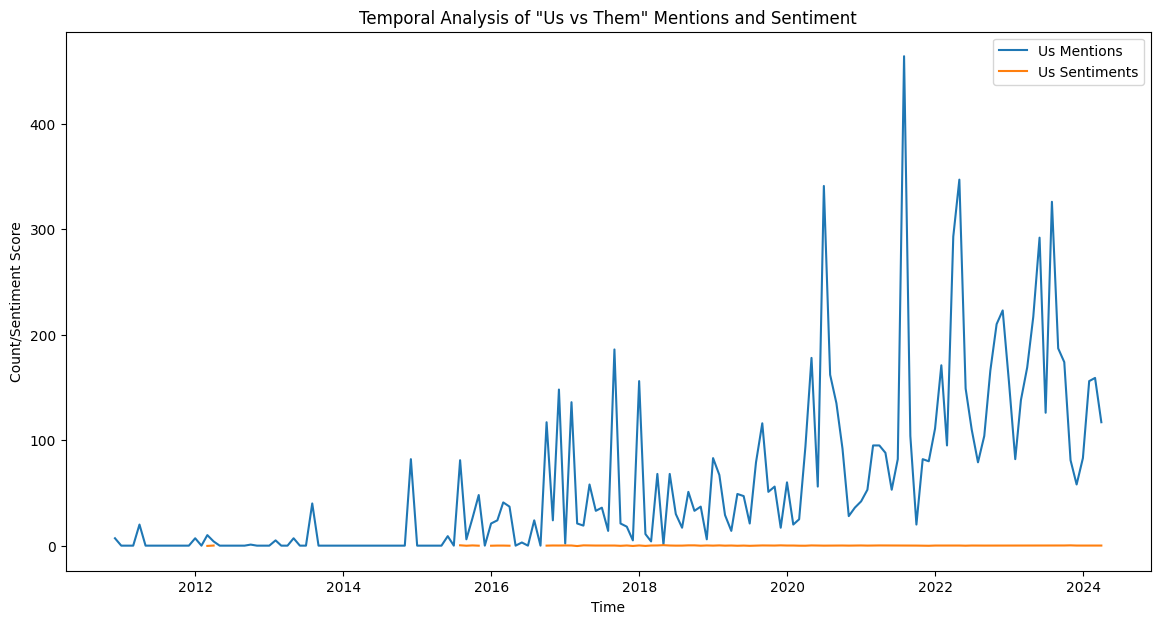

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(monthly_analysis.index, monthly_analysis['us_mentions'], label='Us Mentions')
plt.plot(monthly_analysis.index, monthly_analysis['us_sentiments'], label='Us Sentiments')
plt.legend()
plt.title('Temporal Analysis of "Us vs Them" Mentions and Sentiment')
plt.xlabel('Time')
plt.ylabel('Count/Sentiment Score')
plt.show()

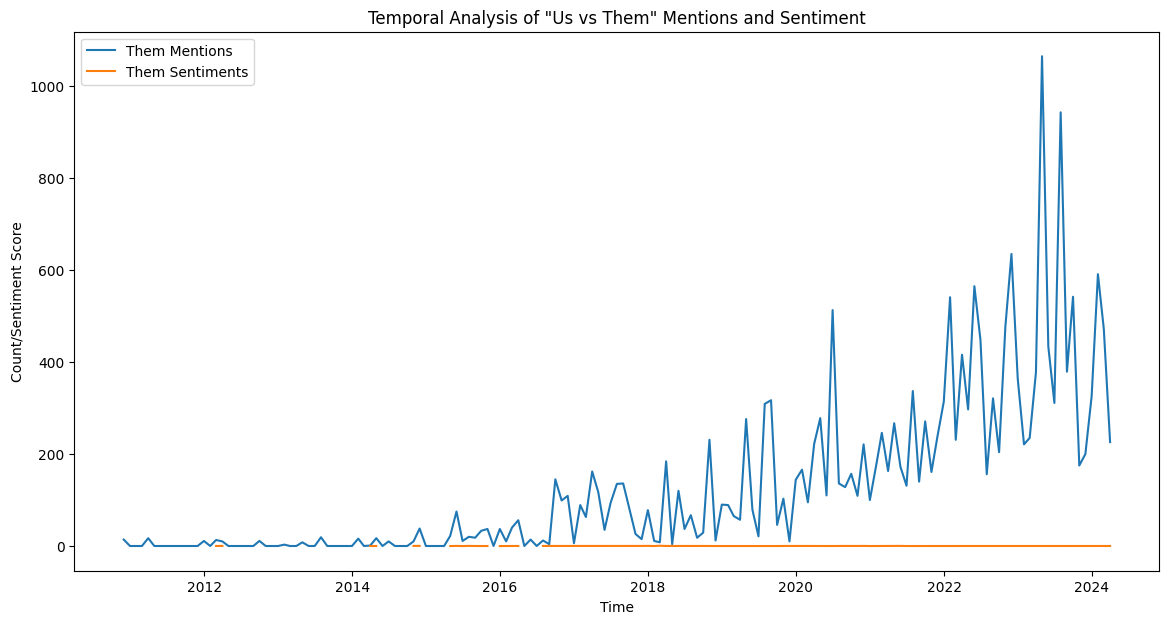

In [29]:
plt.figure(figsize=(14, 7))
plt.plot(monthly_analysis.index, monthly_analysis['them_mentions'], label='Them Mentions')
plt.plot(monthly_analysis.index, monthly_analysis['them_sentiments'], label='Them Sentiments')
plt.legend()
plt.title('Temporal Analysis of "Us vs Them" Mentions and Sentiment')
plt.xlabel('Time')
plt.ylabel('Count/Sentiment Score')
plt.show()

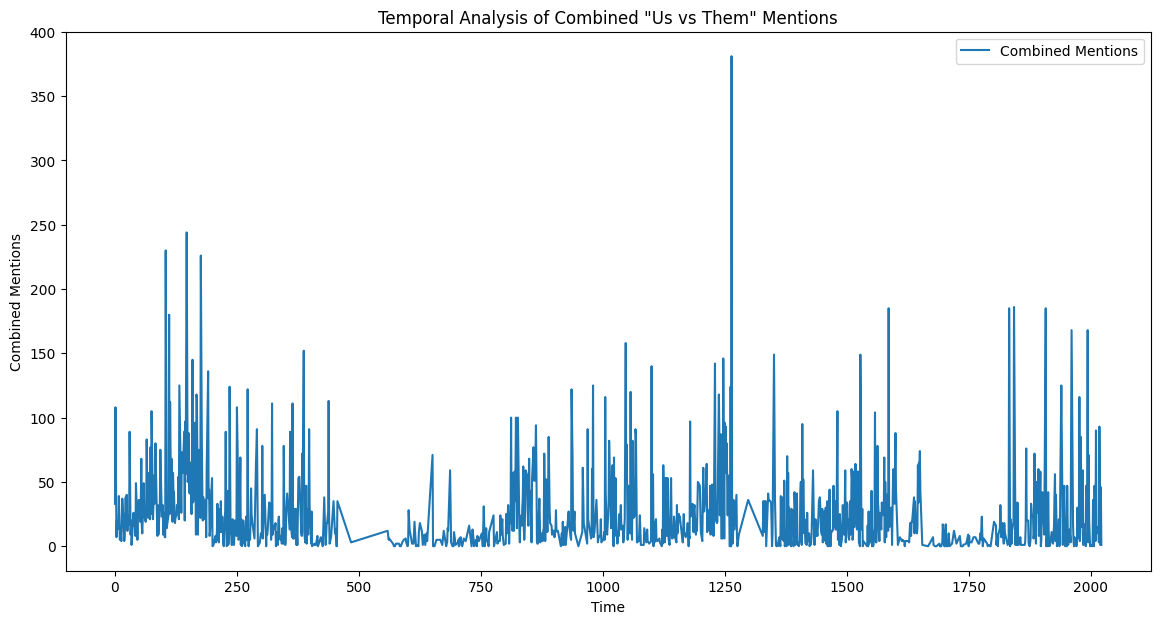

In [49]:
mention_words = ["we", "our", "us", "they", "their", "they're", "them"]

def count_mentions(text):
    count = 0
    words = text.split()
    for word in words:
        if word in mention_words:
            count += 1
    return count

df_uvt['created_utc'] = pd.to_datetime(df_uvt['created_utc'])
df_uvt['combined_mentions'] = df_uvt['post_text'].apply(count_mentions)

# Plot the combined mentions
plt.figure(figsize=(14, 7))
plt.plot(df_uvt.index, df_uvt['combined_mentions'], label='Combined Mentions')
plt.legend()
plt.title('Temporal Analysis of Combined "Us vs Them" Mentions')
plt.xlabel('Time')
plt.ylabel('Combined Mentions')
plt.show()

### SENTIMENT ANALYSIS (polarity and subjectivity)

In [30]:
df_test = pd.read_csv('final_text.csv')

In [31]:
from textblob import TextBlob
import matplotlib.pyplot as plt

df_test['created_utc'] = pd.to_datetime(df_test['created_utc'])

for index, row in df_test.iterrows():
    text = row['post_text']
    comment = row['top_comment']
    if type(text) != str:
        df_test.drop(index, inplace=True)
    elif type(comment) != str:
        df_test.drop(index, inplace=True)

# sentiment analysis
df_test['text_sentiment_polarity'] = df_test['post_text'].apply(lambda text: TextBlob(text).sentiment.polarity)
df_test['comment_sentiment_polarity'] = df_test['top_comment'].apply(lambda text: TextBlob(text).sentiment.polarity)
df_test['text_sentiment_subjectivity'] = df_test['post_text'].apply(lambda text: TextBlob(text).sentiment.subjectivity)
df_test['comment_sentiment_subjectivity'] = df_test['top_comment'].apply(lambda text: TextBlob(text).sentiment.subjectivity)

In [32]:
df_test.to_csv('final_cleaned.csv', index=False)

In [33]:
len(df_test)

1196

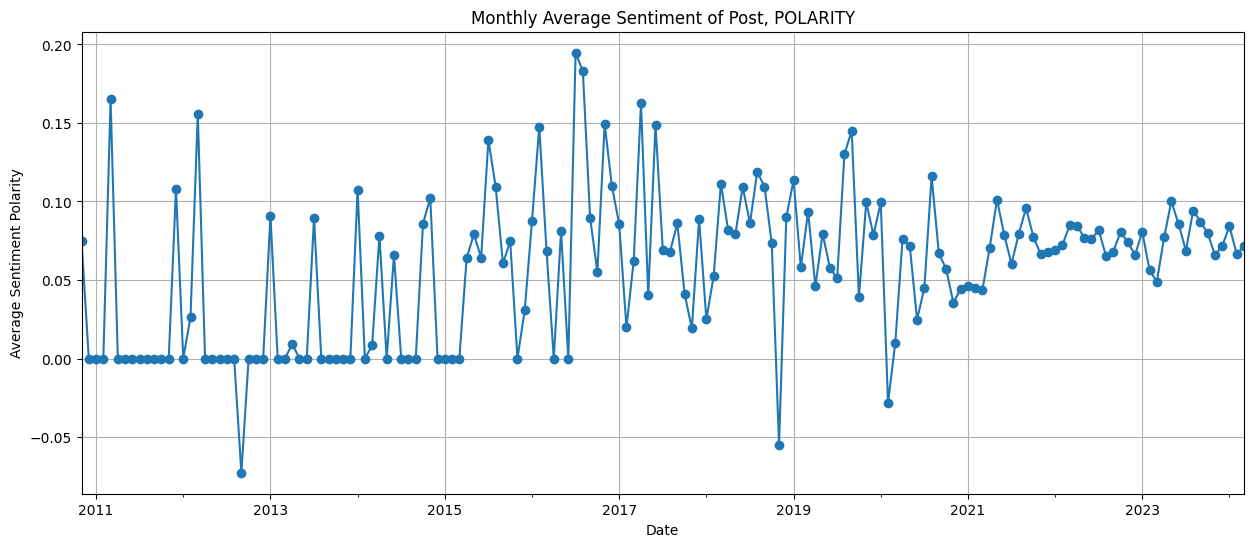

In [34]:
df_test['created_utc'] = pd.to_datetime(df_test['created_utc'])

# can change to D for daily
text_sentiment = df_test.resample('M', on='created_utc')['text_sentiment_polarity'].mean()
text_sentiment = text_sentiment.fillna(0)

plt.figure(figsize=(15, 6))
text_sentiment.plot(kind='line', marker='o', linestyle='-')
plt.title('Monthly Average Sentiment of Post, POLARITY')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Polarity')
plt.grid(True)
plt.show()

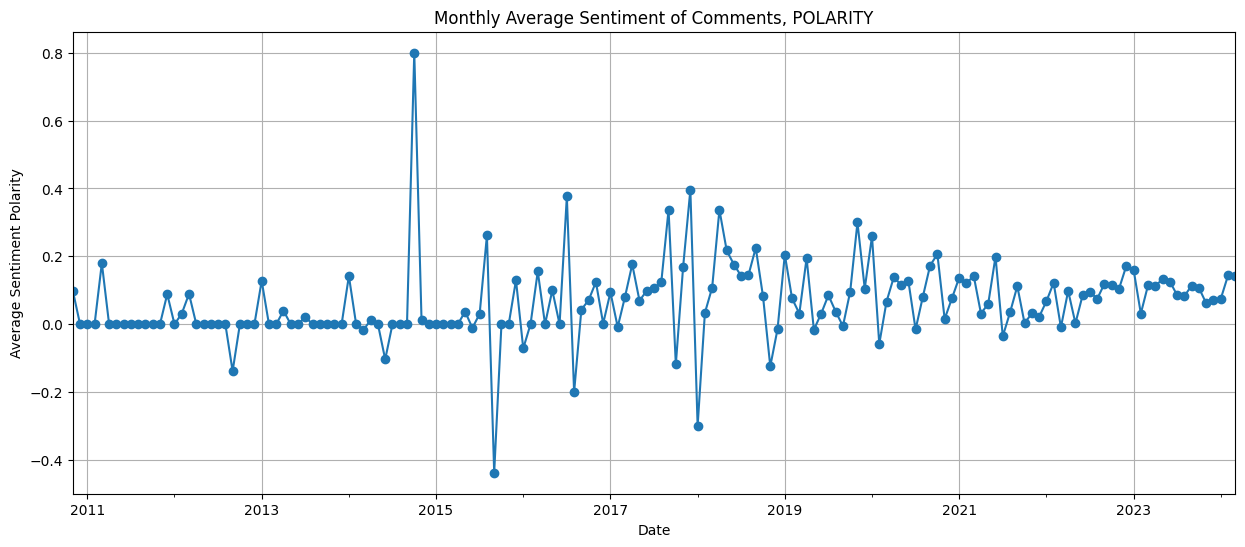

In [35]:
df_test['created_utc'] = pd.to_datetime(df_test['created_utc'])

# can change to D for daily
comment_sentiment = df_test.resample('M', on='created_utc')['comment_sentiment_polarity'].mean()
comment_sentiment = comment_sentiment.fillna(0)

plt.figure(figsize=(15, 6))
comment_sentiment.plot(kind='line', marker='o', linestyle='-')
plt.title('Monthly Average Sentiment of Comments, POLARITY')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Polarity')
plt.grid(True)
plt.show()

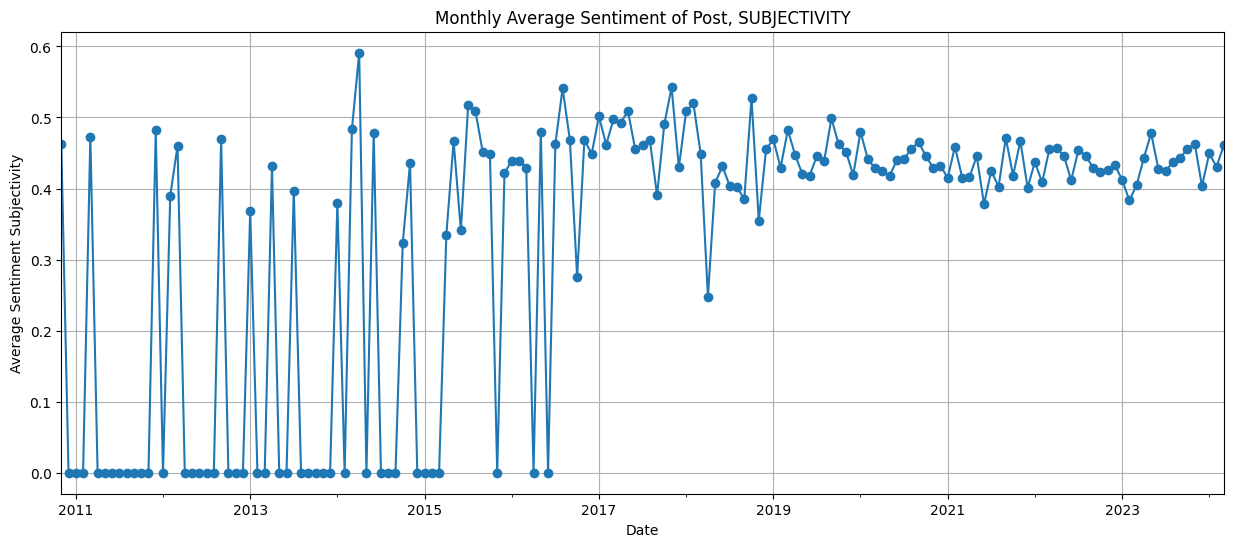

In [36]:
df_test['created_utc'] = pd.to_datetime(df_test['created_utc'])

# can change to D for daily
text_sentiment = df_test.resample('M', on='created_utc')['text_sentiment_subjectivity'].mean()
text_sentiment = text_sentiment.fillna(0)

plt.figure(figsize=(15, 6))
text_sentiment.plot(kind='line', marker='o', linestyle='-')
plt.title('Monthly Average Sentiment of Post, SUBJECTIVITY')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Subjectivity')
plt.grid(True)
plt.show()

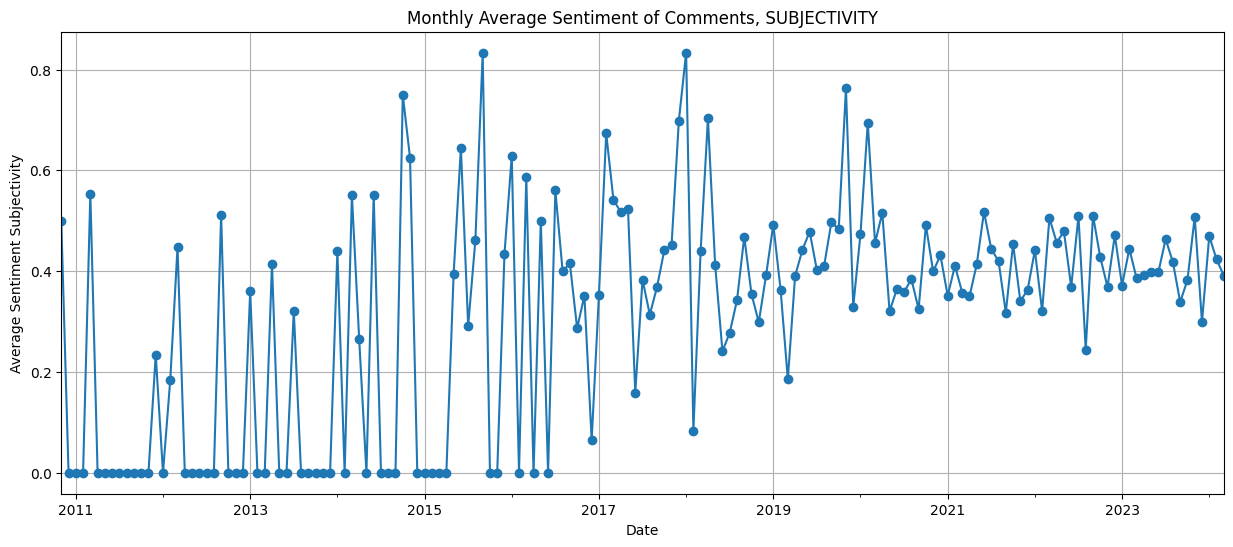

In [37]:
df_test['created_utc'] = pd.to_datetime(df_test['created_utc'])

# can change to D for daily
comment_sentiment = df_test.resample('M', on='created_utc')['comment_sentiment_subjectivity'].mean()
comment_sentiment = comment_sentiment.fillna(0)

plt.figure(figsize=(15, 6))
comment_sentiment.plot(kind='line', marker='o', linestyle='-')
plt.title('Monthly Average Sentiment of Comments, SUBJECTIVITY')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Subjectivity')
plt.grid(True)
plt.show()

### TERM FREQUENCY

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_test.dropna(subset=['post_text'], inplace=True)

vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
vect_fit = vectorizer.fit_transform(df_test['post_text'])

feature_names = vectorizer.get_feature_names_out()

post_tfidf = pd.DataFrame(vect_fit.toarray(), columns=feature_names)
post_tfidf.to_csv('post_tfidf.csv', index=False)

In [39]:
df_test.dropna(subset=['top_comment'], inplace=True)

vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
vect_fit = vectorizer.fit_transform(df_test['top_comment'])

feature_names = vectorizer.get_feature_names_out()

comment_tfidf = pd.DataFrame(vect_fit.toarray(), columns=feature_names)
comment_tfidf.to_csv('comment_tfidf.csv', index=False)

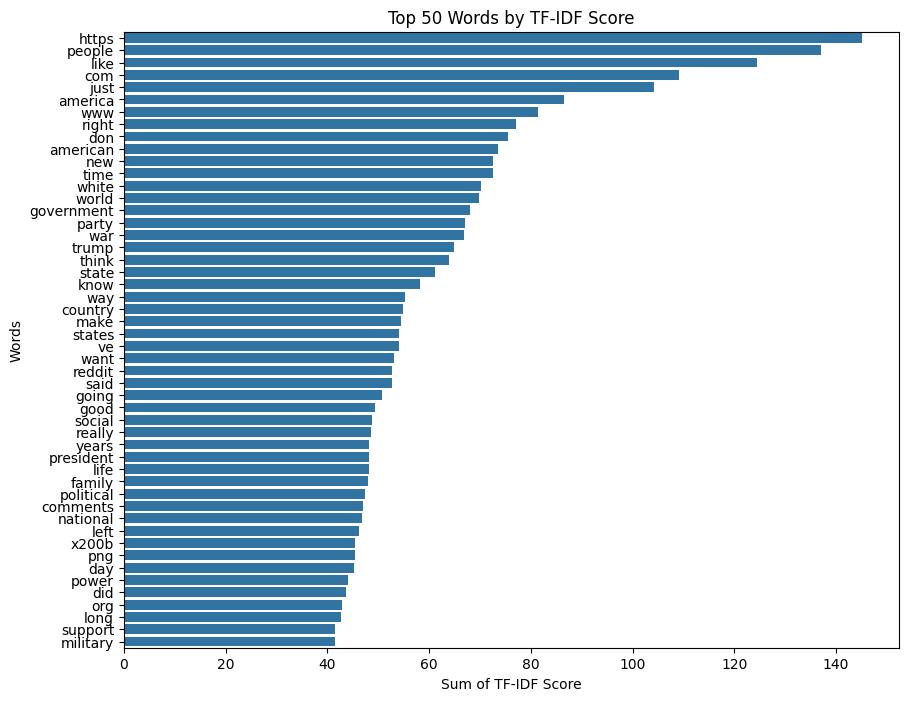

In [40]:
import seaborn as sns

total_post = post_tfidf.sum().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=total_post.values[:50], y=total_post.index[:50])
plt.title('Top 50 Words by TF-IDF Score')
plt.xlabel('Sum of TF-IDF Score')
plt.ylabel('Words')
plt.show()

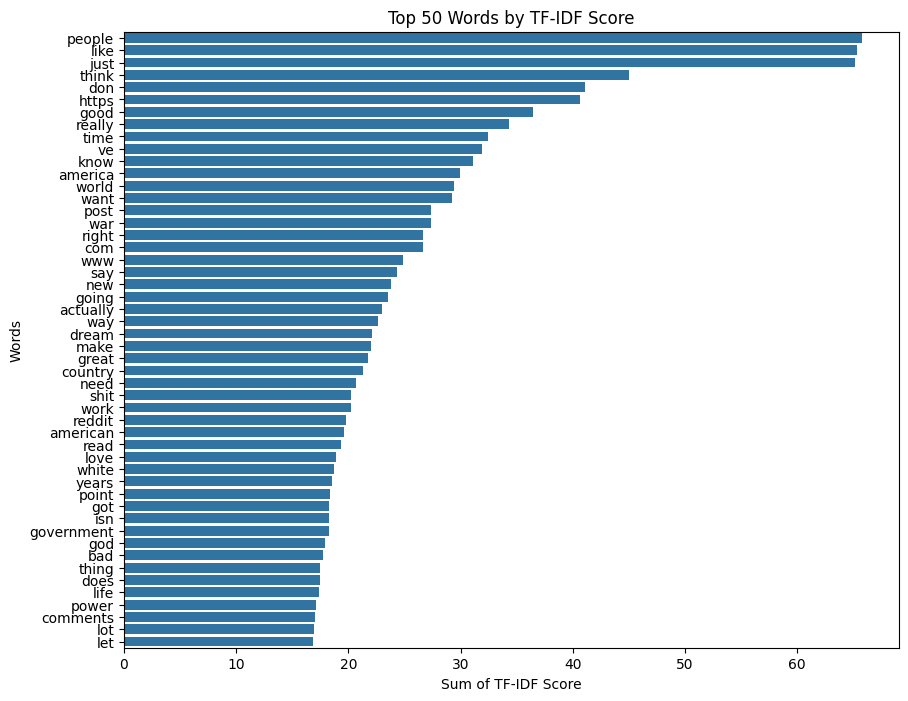

In [41]:
import seaborn as sns

total_comment = comment_tfidf.sum().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=total_comment.values[:50], y=total_comment.index[:50])
plt.title('Top 50 Words by TF-IDF Score')
plt.xlabel('Sum of TF-IDF Score')
plt.ylabel('Words')
plt.show()